CS4650

Roya Salei

### Goal: 
Use machine learning algorithm to predict stock prices for the next 5 days.

To build the stock prediction model, I followed an online blog (https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c). 

These are the Steps:
1. Pick a company
2. Get data from Yahoo finance site (for the last 5 years)
3. Get stock indicators (RSI, MACD, and CCI) from finta library
4. Smooth data with EWMA (exponential weighted moving average)
5. Split data: cut the data into 40-day chunks with a 10-day overlap.
6. Create models (RandomForestClassifier and KNeighborsClassifier)
7. Make predictions (using 15 day sliding window)

With stocks being so volatile, I don't think the prediction just based on the last 15 days is enough to base a decision. So, next week I will explore new ways.    


In [1]:
# !pip install -U yfinance
# # to import technical indicators
# !pip install -U finta   
# !pip install -U pyspark

ERROR: Invalid requirement: '#'


In [38]:
import yfinance as yfin
import datetime
import pandas as pd
import numpy as np
from finta import TA

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [40]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1. Import the Last 5 Years of Data for 'XOM'

In [69]:
# convert 5 years to days
duration = 4 * 12 * 365 
start = (datetime.date.today() - datetime.timedelta(duration))
end = datetime.datetime.today()

# Companies I am following 'GNRC', 'PAYC', 'WTI', 'SMCI', 'XOM'
ticker = 'XOM'
# set interval as 1 day
data = yfin.download(ticker, start=start, end=end, interval='1d')
print(data.shape)

# finta library does use lower case column title
data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close':'adj close', 'Volume': 'volume', }, inplace=True)
print(data.head())

[*********************100%***********************]  1 of 1 completed
(12100, 6)
                open      high       low     close  adj close   volume
Date                                                                  
1974-06-03  2.265625  2.351563  2.265625  2.351563   0.261493  1116800
1974-06-04  2.351563  2.378906  2.335938  2.363281   0.262796  1833600
1974-06-05  2.363281  2.414063  2.332031  2.371094   0.263665  1248000
1974-06-06  2.371094  2.441406  2.355469  2.437500   0.271050  1568000
1974-06-07  2.437500  2.468750  2.417969  2.429688   0.270181  1244800


## 2. Data Processing & Feature Engineering

<AxesSubplot:xlabel='Date'>

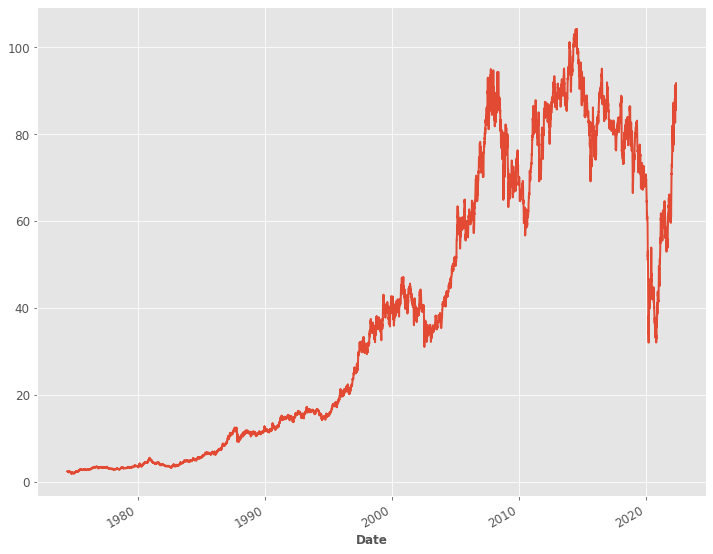

In [70]:
# Smoothing the spikes with exponential weighted moving average(ewm function) an alpha of 0.7 
data = data.ewm(alpha=0.7).mean()
data['close'].plot()

### Compute Technical Indicators

    1. RSI or Relative Strength Index signals about bullish and bearish price momentum. when:
        - RSI > 70% then the asset is considered overbought 
        - RSI < 30% it is considered oversold
    2. MACD stands for Moving average convergence divergence.
        - If MACD of a stock crosses above its signal line it is considered time to buy. 
        - If MACD falls below its signal line, it is considered as time to sell.
    3. CCI or Commodity Channel Index compares current price to average price over a specific time period.         

In [71]:
# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'CCI']

In [72]:
def get_indicator_data(data):
    
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema14'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['adj close'])
    
    return data

data_with_indicators = get_indicator_data(data)
print(data_with_indicators.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '20 period CCI', 'ema50',
       'ema21', 'ema14', 'ema5', 'normVol'],
      dtype='object')


In [73]:
data_with_indicators.head()

,close,14 period RSI,MACD,SIGNAL,20 period CCI,ema50,ema21,ema14,ema5,normVol
Date,,,,,,,,,,
1974-06-03,2.351563,NaN,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1974-06-04,2.360577,100.0,0.000202,0.000112,66.666667,1.001894,1.001868,1.001847,1.001739,1.176804
1974-06-05,2.368143,100.0,0.000492,0.000268,82.346151,1.003364,1.003301,1.003249,1.002986,0.977651
1974-06-06,2.417089,100.0,0.002379,0.000983,113.432259,1.017786,1.017490,1.017240,1.015960,1.052718
1974-06-07,2.425930,100.0,0.003706,0.001793,113.458852,1.016959,1.016489,1.016094,1.014116,0.943673


In [74]:
live_pred_data = data_with_indicators.iloc[-16:-11]
live_pred_data

,close,14 period RSI,MACD,SIGNAL,20 period CCI,ema50,ema21,ema14,ema5,normVol
Date,,,,,,,,,,
2022-04-29,85.549464,53.812258,0.741367,1.066607,25.089575,1.103802,1.029916,1.014595,1.002867,1.179967
2022-05-02,86.151842,55.705444,0.755091,1.004304,23.682960,1.109147,1.035419,1.020260,1.008260,1.185581
2022-05-03,87.578554,59.898053,0.871050,0.977653,71.838639,1.124703,1.050057,1.034593,1.020711,1.117170
2022-05-04,90.463564,66.751403,1.182118,1.018546,171.073033,1.158080,1.080490,1.063805,1.044873,1.300595
2022-05-05,90.356068,66.296769,1.403785,1.095594,161.154805,1.153161,1.075335,1.058129,1.036097,1.211755


### Produce Prdiction function returns 1: Buy, 0: Sell

Using the future values (size of the sliding window) in our data, we can add a column 'pred' to capture the behavior of the data in regarding buying or selling. 

In [62]:
def produce_prediction(data, window):
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = produce_prediction(data_with_indicators, window=15)
data.shape

(12100, 11)

### Clean data

In [63]:
del (data['close'])
data = data.dropna() 
data.tail()

,14 period RSI,MACD,SIGNAL,20 period CCI,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,
2022-04-25,45.930974,1.240113,1.485547,-72.911587,1.083204,1.007014,0.989534,0.971093,1.350859,1.0
2022-04-26,43.568202,0.898223,1.368082,-70.126266,1.072309,0.998404,0.982244,0.968737,1.174286,1.0
2022-04-27,49.169659,0.734152,1.241296,-47.449864,1.088926,1.014959,0.999293,0.987889,1.191629,1.0
2022-04-28,56.409196,0.774400,1.147917,19.437955,1.115132,1.039809,1.023949,1.011638,1.187708,1.0
2022-04-29,53.812258,0.741367,1.066607,25.089575,1.103802,1.029916,1.014595,1.002867,1.179967,1.0


## 3. Model Creation
Due to the nature of time-series’, if we randomize our train-test set, we could encounter a look-ahead bias which is not good for predicting the stock market.
The goal here is to have a sliding window for training and test sets. As shown in the following figure
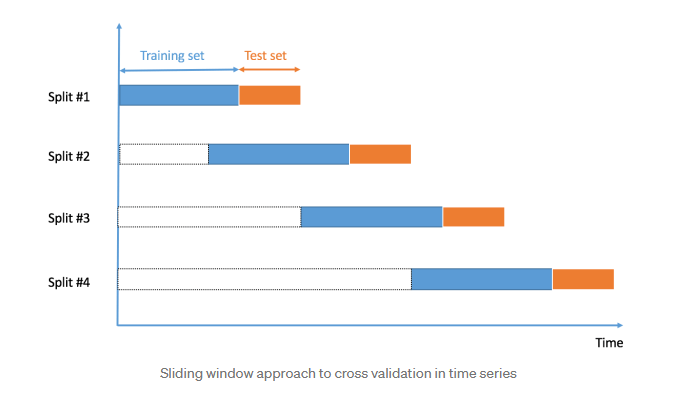
Source of image: https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

In [50]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    
    # Create a tuple list of our models
    #Ensemble methods help to improve the robustness/generalizability of the model. 
    estimators=[('knn', knn), ('rf', rf)]
    # Voting is one of the simplest ways of combining the predictions from multiple machine learning algorithms.
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        
        ensemble.fit(X_train, y_train)
        
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    return ensemble
    
ensemble_model = cross_Validation(data)

RF Accuracy = 0.6044951590594747
KNN Accuracy = 0.5621023513139694
ENSEMBLE Accuracy = 0.5951590594744123


## 4. Verification of Results

In [64]:
del(live_pred_data['close'])

In [65]:
print(live_pred_data)

            14 period RSI      MACD    SIGNAL  20 period CCI     ema50  \
Date                                                                     
2022-04-29      53.812258  0.741367  1.066607      25.089575  1.103802   
2022-05-02      55.705444  0.755091  1.004304      23.682960  1.109147   
2022-05-03      59.898053  0.871050  0.977653      71.838639  1.124703   
2022-05-04      66.751403  1.182118  1.018546     171.073033  1.158080   
2022-05-05      66.296769  1.403785  1.095594     161.154805  1.153161   

               ema21     ema15      ema5   normVol  
Date                                                
2022-04-29  1.029916  1.014595  1.002867  1.179967  
2022-05-02  1.035419  1.020260  1.008260  1.185581  
2022-05-03  1.050057  1.034593  1.020711  1.117170  
2022-05-04  1.080490  1.063805  1.044873  1.300595  
2022-05-05  1.075335  1.058129  1.036097  1.211755  


In [66]:
prediction = ensemble_model.predict(live_pred_data)

In [67]:
import datetime 
import time

print("Prediction result for {}".format(ticker))
print("--------------------------")
for i, k in zip(live_pred_data.index, prediction):
    d = i + datetime.timedelta(15)
    dt = d.strftime('%a %b %d, %Y')
    if(k == 1):
        print ("Buy on {}".format(dt))
    else:
        print ("Sell on {}".format(dt))
print("--------------------------")

Prediction result for XOM
--------------------------
Buy on Sat May 14, 2022
Buy on Tue May 17, 2022
Buy on Wed May 18, 2022
Sell on Thu May 19, 2022
Buy on Fri May 20, 2022
--------------------------
